In [1]:
!pip install -q networkx==3.2.1 gluonts==0.14.2 pyarrow==15.0.0 tqdm


In [2]:
import functools
import random
from pathlib import Path
from typing import Dict, List, Optional

import numpy as np
import networkx as nx
from tqdm.auto import tqdm
from gluonts.dataset.arrow import ArrowWriter
from sklearn.gaussian_process.kernels import (
    ExpSineSquared,
    DotProduct,
    RBF,
    RationalQuadratic,
    WhiteKernel,
    ConstantKernel,
)

# =========================================================
# Global hyper‑parameters
# =========================================================
LENGTH = 512  # length of every time series


In [3]:
# ---------------------------------------------------------
# 2.1  Build a “kernel bank” for KernelSynth
# ---------------------------------------------------------
KERNEL_BANK = [
    # Hourly seasonality
    ExpSineSquared(periodicity=24 / LENGTH),
    ExpSineSquared(periodicity=48 / LENGTH),
    ExpSineSquared(periodicity=96 / LENGTH),
    # Weekly seasonality
    ExpSineSquared(periodicity=24 * 7 / LENGTH),
    ExpSineSquared(periodicity=48 * 7 / LENGTH),
    ExpSineSquared(periodicity=96 * 7 / LENGTH),
    # Daily/Monthly/Yearly & misc.
    ExpSineSquared(periodicity=7 / LENGTH),
    ExpSineSquared(periodicity=14 / LENGTH),
    ExpSineSquared(periodicity=30 / LENGTH),
    ExpSineSquared(periodicity=60 / LENGTH),
    ExpSineSquared(periodicity=365 / LENGTH),
    ExpSineSquared(periodicity=2 * 365 / LENGTH),
    DotProduct(sigma_0=0.0),
    DotProduct(sigma_0=1.0),
    DotProduct(sigma_0=10.0),
    RBF(length_scale=0.1),
    RBF(length_scale=1.0),
    RBF(length_scale=10.0),
    RationalQuadratic(alpha=0.1),
    RationalQuadratic(alpha=1.0),
    RationalQuadratic(alpha=10.0),
    WhiteKernel(noise_level=0.1),
    WhiteKernel(noise_level=1.0),
    ConstantKernel(),
]

def random_binary_map(a, b):
    """Randomly combine two kernels by + or *."""
    return np.random.choice([lambda x, y: x + y, lambda x, y: x * y])(a, b)

# ---------------------------------------------------------
# 2.2  Mean‑function primitives
# ---------------------------------------------------------
def zero_mean(x):       # baseline zero
    return np.zeros_like(x)

def linear_mean(x):     # ax + b
    a, b = np.random.uniform(-1.0, 1.0, 2)
    return a * x + b

def exponential_mean(x):  # a·e^{b·x}
    a, b = np.random.uniform(0.5, 1.5, 2)
    return a * np.exp(b * x)

def anomaly_mean(x):     # a few random spikes
    m = np.zeros_like(x)
    for _ in range(np.random.randint(1, 6)):
        idx = np.random.randint(0, len(x))
        m[idx] += np.random.uniform(-5.0, 5.0)
    return m

def random_mean_combination(x):
    """Pick two mean functions and combine them (sum or product)."""
    f1, f2 = np.random.choice(
        [zero_mean, linear_mean, exponential_mean, anomaly_mean],
        2,
        replace=True,
    )
    op = np.random.choice([lambda u, v: u + v, lambda u, v: u * v])
    return op(f1(x), f2(x))

# ---------------------------------------------------------
# 2.3  Sample from GP prior (CPU)
# ---------------------------------------------------------
def sample_from_gp_prior_cpu(
    kernel,
    X: np.ndarray,
    mean_vec: Optional[np.ndarray] = None,
    random_seed: Optional[int] = None,
):
    """
    Draw a single trajectory from a GP with given kernel & mean.
    """
    if X.ndim == 1:
        X = X[:, None]

    cov = kernel(X)  # (N, N)
    N = X.shape[0]
    if mean_vec is None:
        mean_vec = np.zeros(N)

    if random_seed is not None:
        np.random.seed(random_seed)

    return np.random.multivariate_normal(mean=mean_vec, cov=cov)

# ---------------------------------------------------------
# 2.4  Non‑linear “edge” activation for SCM
# ---------------------------------------------------------
def random_activation(x, kind="linear"):
    if kind == "linear":
        a, b = np.random.uniform(0.5, 2.0), np.random.uniform(-1.0, 1.0)
        return a * x + b
    if kind == "relu":
        return np.maximum(0.0, x)
    if kind == "sigmoid":
        return 1.0 / (1.0 + np.exp(-x))
    if kind == "sin":
        return np.sin(x)
    if kind == "mod":
        c = np.random.uniform(1.0, 5.0)
        return np.mod(x, c)
    # leaky‑relu
    alpha = np.random.uniform(0.01, 0.3)
    return np.where(x > 0, x, alpha * x)

def random_edge_mapping(parents_data: List[np.ndarray]) -> np.ndarray:
    """Linear mix + random activation."""
    combined = np.vstack(parents_data).T
    w = np.random.randn(combined.shape[1])
    b = np.random.randn()
    lin = combined @ w + b
    act = np.random.choice(
        ["linear", "relu", "sigmoid", "sin", "mod", "leakyrelu"]
    )
    return random_activation(lin, act)

# ---------------------------------------------------------
# 2.5  Random DAG generator
# ---------------------------------------------------------
def generate_random_dag(num_nodes: int, max_parents: int = 3):
    order = list(range(num_nodes))
    random.shuffle(order)
    g = nx.DiGraph()
    g.add_nodes_from(order)
    for i in range(num_nodes):
        potential = order[:i]
        k = np.random.randint(0, min(len(potential), max_parents) + 1)
        for p in random.sample(potential, k):
            g.add_edge(p, order[i])
    return g


In [4]:
def _generate_scm_graph(
    time_length: int,
    num_nodes: int,
    max_parents: int,
    seed: int,
) -> Dict[int, np.ndarray]:
    """
    Build a random causal DAG and sample one time series per node.
    """
    np.random.seed(seed)
    random.seed(seed)

    dag = generate_random_dag(num_nodes, max_parents)
    node_data: Dict[int, np.ndarray] = {}
    roots = [n for n in dag.nodes if dag.in_degree(n) == 0]
    x_grid = np.linspace(0, 1, time_length)

    # 1) root nodes ~ GP
    for r in roots:
        kernels = np.random.choice(KERNEL_BANK, np.random.randint(1, 4), replace=True)
        kernel = functools.reduce(random_binary_map, kernels)
        mean_vec = random_mean_combination(x_grid)
        node_data[r] = sample_from_gp_prior_cpu(kernel, x_grid, mean_vec)

    # 2) internal nodes = f(parents)
    for node in nx.topological_sort(dag):
        if node in roots:
            continue
        parents = list(dag.predecessors(node))
        parent_ts = [node_data[p] for p in parents]
        node_data[node] = random_edge_mapping(parent_ts)

    return node_data


In [5]:
def generate_scm_dataset(
    num_series: int = 500,
    time_length: int = 512,
    num_features: int = 6,
    max_parents: int = 3,
    num_nodes: int = 6,
    seed: int = 42,
) -> List[Dict]:
    """
    Produce `num_series` GluonTS‑compatible samples.
    """
    results: List[Dict] = []
    rng_global = np.random.default_rng(seed)

    for batch in tqdm(range(num_series // num_features), desc="Batches"):
        current_seed = seed + batch * 100
        graph = _generate_scm_graph(
            time_length, num_nodes, max_parents, current_seed
        )
        sampled_nodes = rng_global.choice(
            list(graph.keys()), size=num_features, replace=False
        )
        for n in sampled_nodes:
            results.append(
                {
                    "start": np.datetime64("2000-01-01 00:00", "s"),
                    "target": graph[n].astype(np.float32),
                }
            )

    return results


In [6]:
# ---------------------------------------------------------
# Parameters you may tweak in Colab UI
# ---------------------------------------------------------
NUM_SERIES  =  20   # total #samples to output
TIME_LENGTH =  512
OUT_FILE    = "scm_demo.arrow"

# Generate
dataset = generate_scm_dataset(
    num_series=NUM_SERIES,
    time_length=TIME_LENGTH,
    max_parents=4,
    num_features=10,   # how many nodes taken per DAG
    num_nodes=20,
    seed=42,
)

# Save to Arrow
ArrowWriter(compression="lz4").write_to_file(dataset, path=OUT_FILE)
print(f"Saved ✅ →  {Path(OUT_FILE).resolve()}")


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Saved ✅ →  /content/scm_demo.arrow


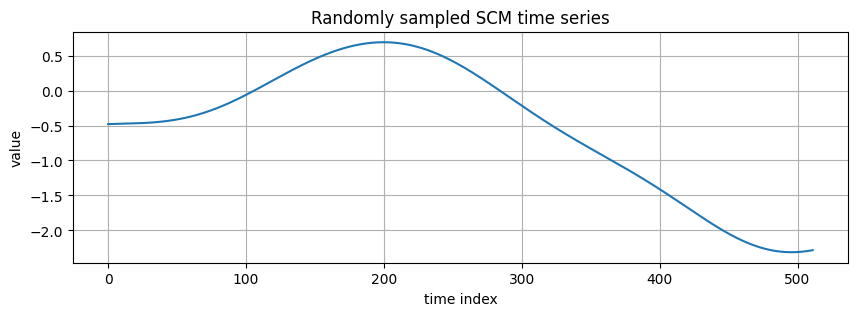

In [7]:
import matplotlib.pyplot as plt
import random

sample = random.choice(dataset)   # pick one sample dict
series = sample["target"]

plt.figure(figsize=(10, 3))
plt.plot(series)
plt.title("Randomly sampled SCM time series")
plt.xlabel("time index")
plt.ylabel("value")
plt.grid(True)
plt.show()
